In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
data = pd.read_csv("engine_data.csv")
data.head(5)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [ ]:
data.dtypes


,0
Engine rpm,int64
Lub oil pressure,float64
Fuel pressure,float64
Coolant pressure,float64
lub oil temp,float64
Coolant temp,float64
Engine Condition,int64


In [ ]:
data.describe()


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433,0.630509
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749,0.482679
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325,0.000000
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421,0.000000
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662,1.000000
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411,1.000000
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912,1.000000


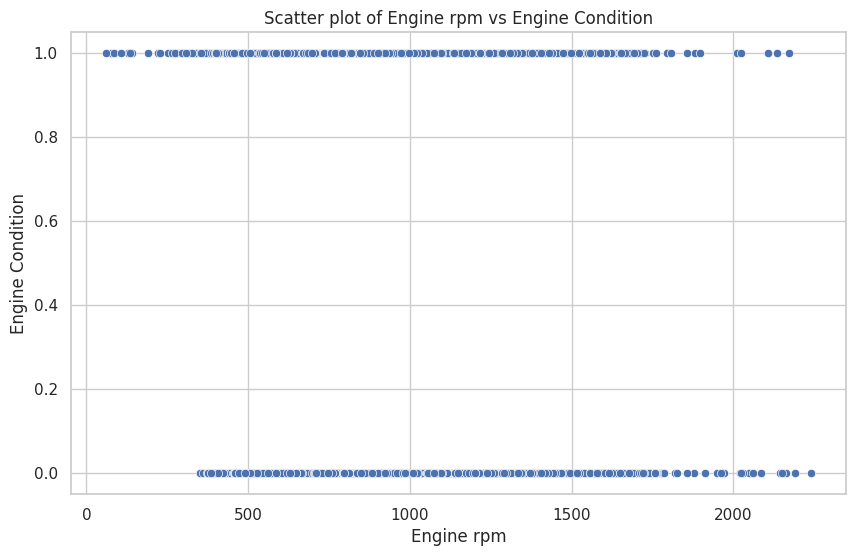

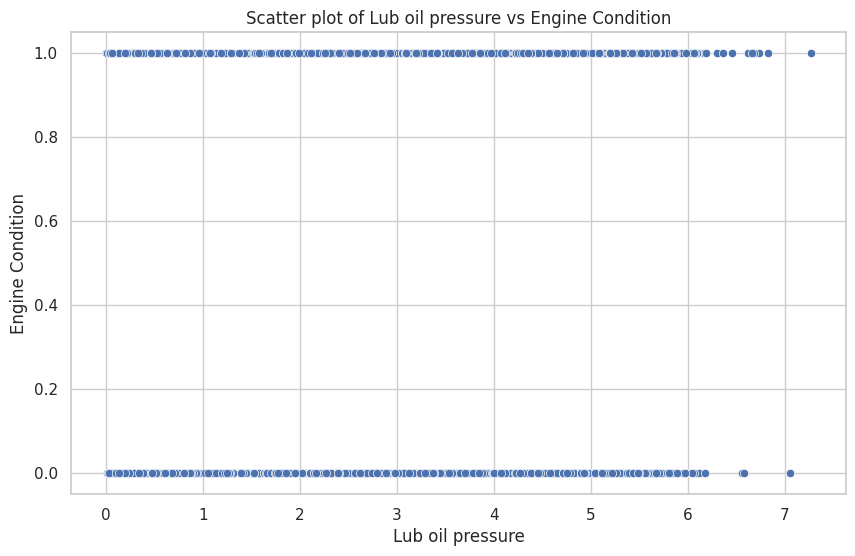

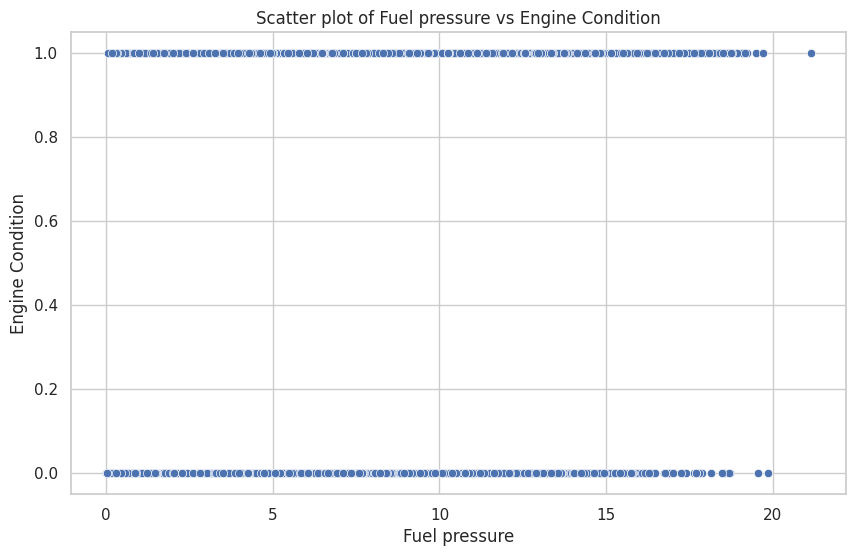

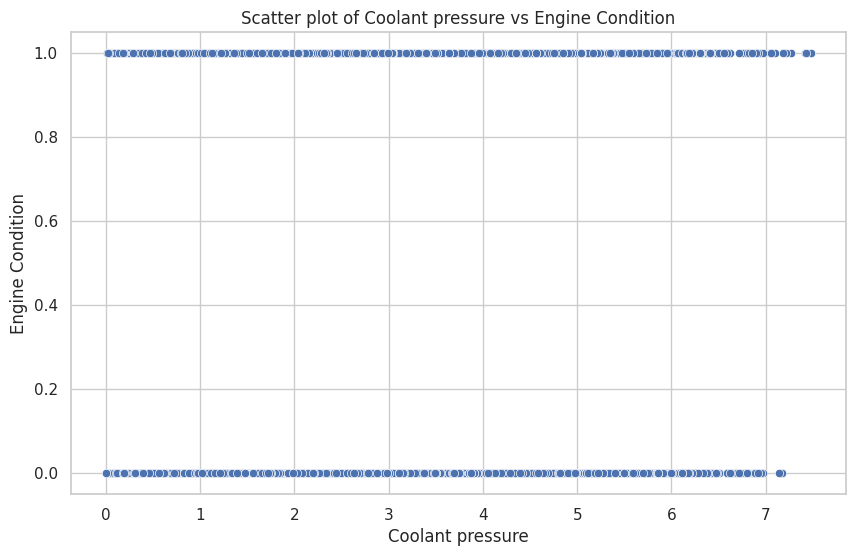

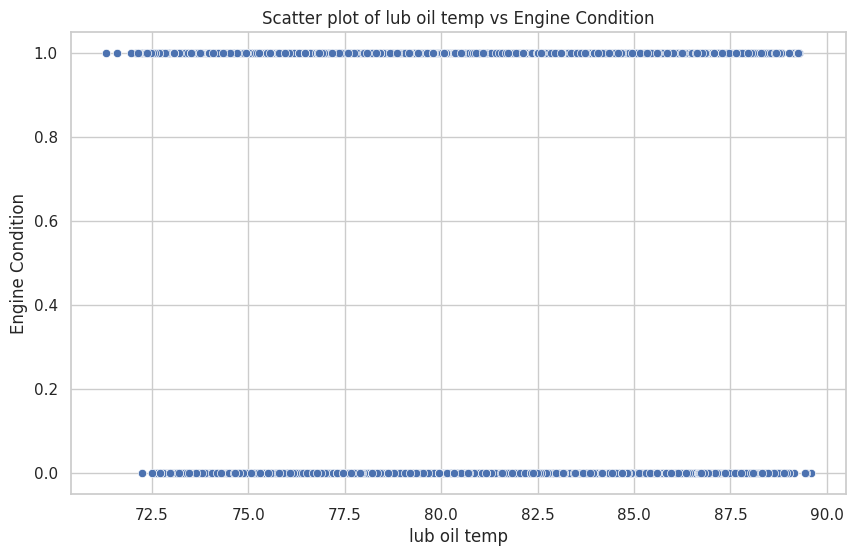

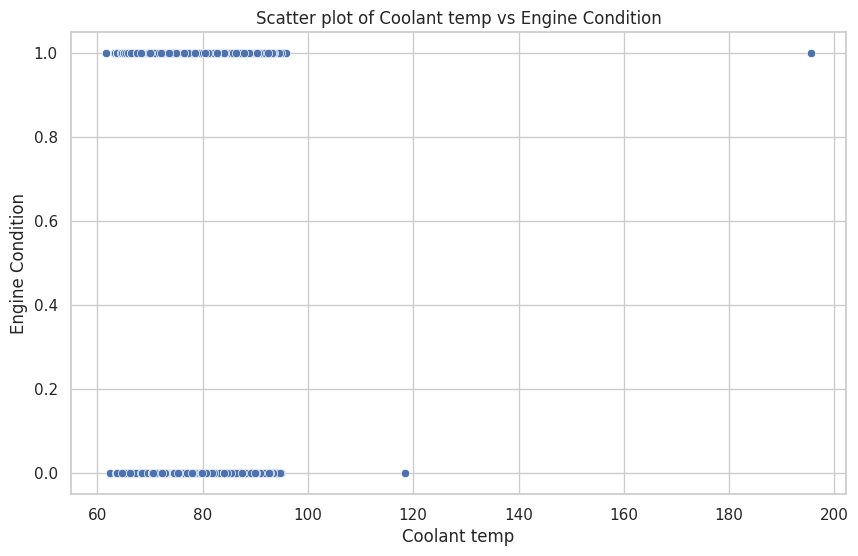

In [ ]:
## Scatter plot with features and output label
sns.set(style="whitegrid")


features = ['Engine rpm', 'Lub oil pressure','Fuel pressure', 'Coolant pressure', 'lub oil temp', 'Coolant temp']
label = 'Engine Condition' # 0 maintenance needed , 1 engine is in good condition


for feature in features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y = label, data=data)
    plt.title(f"Scatter plot of {feature} vs {label}")
    plt.xlabel(feature)
    plt.ylabel('Engine Condition')
    plt.show()

In [ ]:
data['Engine Condition'].value_counts()


,count
Engine Condition,
1,12317
0,7218


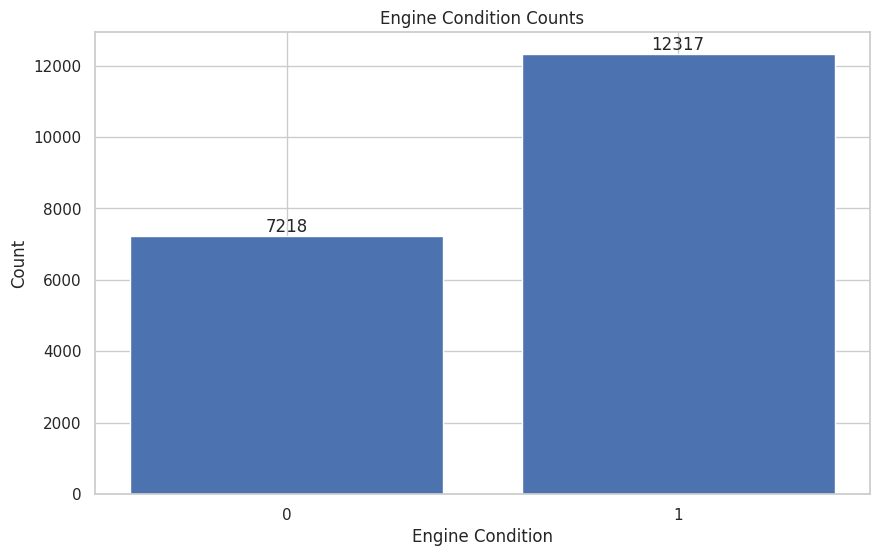

In [ ]:
# Data
conditions = ['0', '1']
counts = [7218, 12317]

plt.figure(figsize=(10, 6))
plt.bar(conditions, counts)

plt.title('Engine Condition Counts')
plt.xlabel('Engine Condition')
plt.ylabel('Count')

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

**Tensor Model**

In [ ]:
X = data.drop(columns=['Engine Condition']).values
y = data['Engine Condition'].values # label output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Turn into tensor

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  #  y  [n, 1]
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
len(X_train_tensor), len(X_test_tensor), len(y_train_tensor), len(y_test_tensor)

(15628, 3907, 15628, 3907)

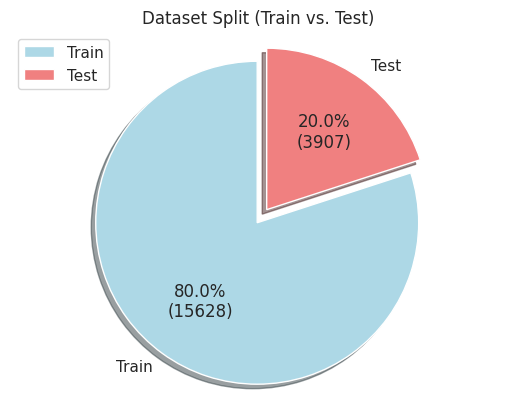

In [ ]:
labels = ['Train', 'Test']
sizes = [len(X_train_tensor), len(X_test_tensor)]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # To explode the first slice

def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda pct: func(pct, sizes), shadow=True, startangle=90)

plt.axis('equal')
plt.title('Dataset Split (Train vs. Test)')
plt.legend(loc='upper left')
plt.show()

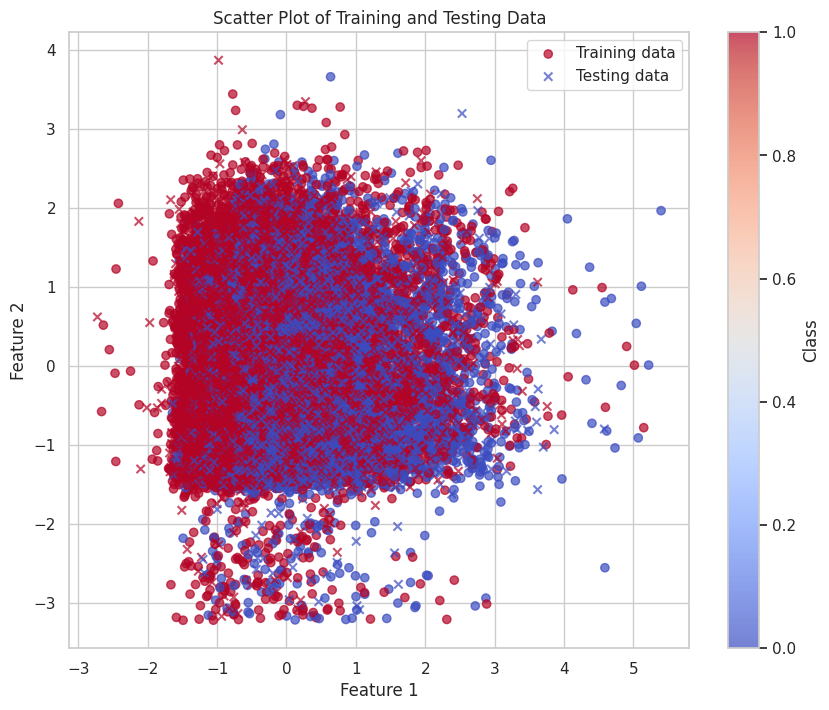

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 8))

# Plot training data
plt.scatter(X_train_tensor[:, 0].detach(), X_train_tensor[:, 1].detach(),
            c=y_train_tensor.detach(), cmap='coolwarm', alpha=0.7, label='Training data')

# Plot testing data
plt.scatter(X_test_tensor[:, 0].detach(), X_test_tensor[:, 1].detach(),
            c=y_test_tensor.detach(), cmap='coolwarm', marker='x', alpha=0.7, label='Testing data')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Training and Testing Data')
plt.legend()
plt.colorbar(label='Class')

plt.show()

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle = False)

In [ ]:
class Condition_Predictor(nn.Module):
    def __init__(self, input_size):
        super(Condition_Predictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(64) # Batch Normalization after the first layer
        self.batch_norm2 = nn.BatchNorm1d(128)  # Second layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid function in the last layer of binary classification

        # forward propagation
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)  #  Batch Normalization
        x = self.relu(x)
        #x = self.dropout(x)      # Dropout

        x = self.fc2(x)
        x = self.batch_norm2(x)  # Batch Normalization
        x = self.relu(x)
        #x = self.dropout(x)      # Dropout

        x = self.fc3(x)
        x = self.relu(x)
        #x = self.dropout(x)      # Dropout

        x = self.fc4(x)
        x = self.sigmoid(x)      # 0 , 1
        return x

input_size = X_train.shape[1]
model = Condition_Predictor(input_size)
model.load_state_dict

<bound method Module.load_state_dict of Condition_Predictor(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)>

In [ ]:
loss_fn = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)  # AdamW to regularization (weight decay)

# Learning Rate Scheduling
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions / total_predictions

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [],[]

epochs = 100

In [ ]:
for epoch in range(epochs):

    ### training loop 5 steps ---train_loader
    model.train()
    running_loss = 0.0

    # Forward pass
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Adaptive Learning Schedule Update
        scheduler.step(loss)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    if (epoch+1) % 20 == 0:
        train_acc = calculate_accuracy(model, train_loader)
        test_acc = calculate_accuracy(model, test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


    ### testing loop-- test loader
    test_acc = calculate_accuracy(model, test_loader)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    y_pred = []
    y_true = []

    with torch.no_grad() :
        # forward pass
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()

            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = len(test_loader)
    test_losses.append(test_loss)

    # calculate acc and loss
    train_acc = calculate_accuracy(model, train_loader)
    test_acc = calculate_accuracy(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print("Classification Report:\n", classification_report(y_true, y_pred))

Final Test Accuracy: 0.6335
Final Test Accuracy: 0.6360
Final Test Accuracy: 0.6314
Final Test Accuracy: 0.6332
Final Test Accuracy: 0.6348
Final Test Accuracy: 0.6337
Final Test Accuracy: 0.6340
Final Test Accuracy: 0.6317
Final Test Accuracy: 0.6317
Final Test Accuracy: 0.6330
Final Test Accuracy: 0.6337
Final Test Accuracy: 0.6332
Final Test Accuracy: 0.6319
Final Test Accuracy: 0.6355
Final Test Accuracy: 0.6330
Final Test Accuracy: 0.6350
Final Test Accuracy: 0.6355
Final Test Accuracy: 0.6332
Final Test Accuracy: 0.6322
Epoch 20/100, Loss: 0.6271799632742361, Train Accuracy: 0.6425, Test Accuracy: 0.6332
Final Test Accuracy: 0.6332
Final Test Accuracy: 0.6312
Final Test Accuracy: 0.6365
Final Test Accuracy: 0.6348
Final Test Accuracy: 0.6314
Final Test Accuracy: 0.6312
Final Test Accuracy: 0.6345
Final Test Accuracy: 0.6363
Final Test Accuracy: 0.6327
Final Test Accuracy: 0.6337
Final Test Accuracy: 0.6314
Final Test Accuracy: 0.6355
Final Test Accuracy: 0.6340
Final Test Accurac

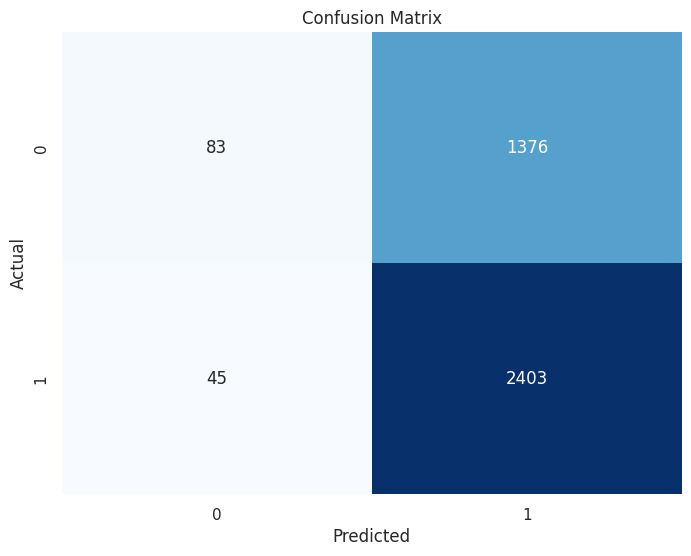

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

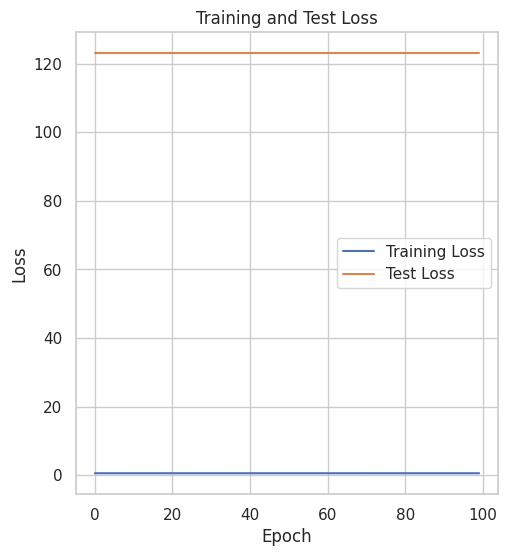

In [ ]:
# Loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

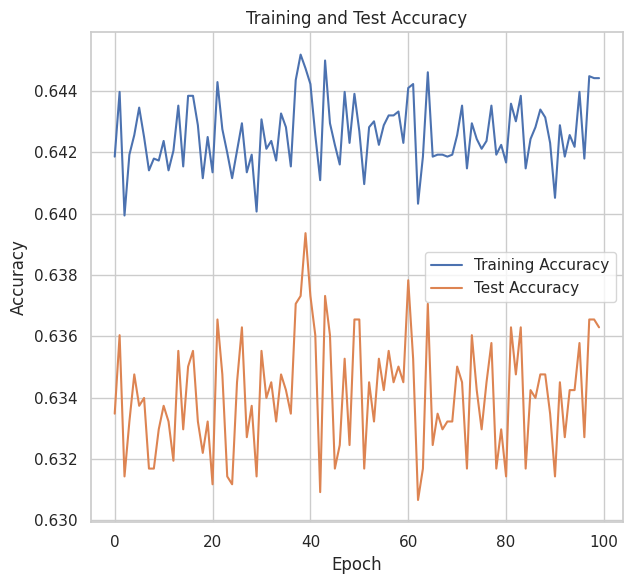

In [ ]:
# Acc curve

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
with torch.inference_mode():
    y_preds = (model(X_test_tensor) >= 0.5).float()

# DataFrame between True and predication vlaues
df_preds = pd.DataFrame({
    "True Values": y_test_tensor.cpu().numpy().flatten(),
    "Predictions": y_preds.cpu().numpy().flatten()
})

print(df_preds)

correct_preds = (df_preds["True Values"] == df_preds["Predictions"]).sum()
incorrect_preds = len(df_preds) - correct_preds

print(f"Correct Predictions: {correct_preds}")
print(f"Incorrect Predictions: {incorrect_preds}")
print(f"Accuracy: {(correct_preds / len(df_preds)) * 100:.2f}%")

      True Values  Predictions
0             0.0          1.0
1             1.0          1.0
2             0.0          1.0
3             1.0          1.0
4             1.0          1.0
...           ...          ...
3902          1.0          1.0
3903          1.0          1.0
3904          0.0          1.0
3905          1.0          1.0
3906          0.0          1.0

[3907 rows x 2 columns]
Correct Predictions: 2486
Incorrect Predictions: 1421
Accuracy: 63.63%


In [ ]:
data

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0
...,...,...,...,...,...,...,...
19530,902,4.117296,4.981360,4.346564,75.951627,87.925087,1
19531,694,4.817720,10.866701,6.186689,75.281430,74.928459,1
19532,684,2.673344,4.927376,1.903572,76.844940,86.337345,1
19533,696,3.094163,8.291816,1.221729,77.179693,73.624396,1


In [ ]:
# input new data == number of features '7 f'
new_data = [[700, 2.49, 11.8, 6.4, 80, 87]]

# convert to Tensor
new_data_tensor = torch.tensor(new_data, dtype=torch.float32)

# predication
model.eval()
with torch.inference_mode():
  new_logits = model(new_data_tensor)  # Passing new data to the model
  new_pred = torch.argmax(new_logits, dim=1)

print("Predicted class:", new_pred.item())

Predicted class: 0


In [ ]:
torch.save(model.state_dict(), 'model_engine-health.pth')

**KNN Model**

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
rs = RobustScaler()

In [ ]:
y = data['Engine Condition']
x = data.drop('Engine Condition',axis=1)

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.30,random_state=42)

In [ ]:
xtrain = pd.DataFrame(rs.fit_transform(xtrain),columns=xtrain.columns)
xtest = pd.DataFrame(rs.fit_transform(xtest),columns=xtrain.columns)

In [ ]:
knn=KNeighborsClassifier()

In [ ]:
knn = KNeighborsClassifier()
params = [{'n_neighbors':[3,5,7,9,11],'metric':['euclidean','manhattan']}]
grd = GridSearchCV(estimator=knn,param_grid=params)
grd_model = grd.fit(xtrain,ytrain)
grd_model.best_params_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'metric': 'euclidean', 'n_neighbors': 11}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11,metric='euclidean')
knn_model = knn.fit(xtrain,ytrain)
knn_model

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [ ]:
y_pred_train = knn_model.predict(xtrain)
y_pred_test = knn_model.predict(xtest)

In [ ]:
accuracy_score(ytrain,y_pred_train),accuracy_score(ytest,y_pred_test)

(0.7152991077958168, 0.6416993687084115)

**Feature Importance**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

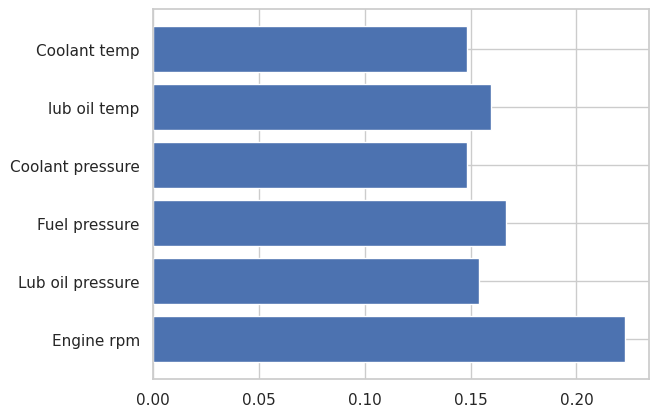

In [ ]:
plt.barh(xtrain.columns,rf.fit(xtrain,ytrain).feature_importances_)
plt.show()